# Memory usage for FlexDriver and CPU driver

This notebook estimates the memory usage for an mlx5 driver for RDMA and compares it to the memory usage for FlexDriver.

In [1]:
%config InlineBackend.figure_format = 'retina'

from copy import copy

import numpy as np
import pandas as pd
import plotnine as p9

from common import *

In [2]:
def log2(value):
    return np.ceil(np.log2(value)).astype('int')

In [3]:
def round_pow2(value):
    return np.left_shift(1, log2(value))

In [4]:
def cuckoo_hash(tag_size, value_size):
    '''Compute the size of the cuckoo hash table in bytes.'''
    num_banks = 4
    num_entries = 2 * round_pow2(value_size) / num_banks
    tag_width = log2(tag_size)
    value_width = log2(value_size)
    return num_banks * num_entries * (tag_width + value_width) / 8

In [5]:
def bdp(df):
    '''Compute the bandwidth-delay product.'''
    linerate = df['linerate_gbps']
    df[f'packet_rate_mpps'] = linerate / (df['min_packet_size_bytes'] + 20) * 125
    for dir in ('tx', 'rx'):
        latency = df[f'latency_{dir}_usec']
        df[f'{dir}_bdp_bytes'] = np.ceil(linerate * latency * 125)
        df[f'{dir}_bdp_descs'] = np.ceil(df['packet_rate_mpps'] * latency)

In [6]:
def outstanding_buffer_fragmentation(df):
    '''Compute necessary buffer size for outstanding receive/transmit packets,
    taking fragmentation into account.'''

    # Use double the computed size for fragmentation (assumes minimal packet size >= block size)
    assert (df['fld_tx_data_block_bytes'] <= df['min_packet_size_bytes']).all()
    rx_stride = 64 # byte
    assert (rx_stride <= df['min_packet_size_bytes']).all()
    # Standard SRQ uses same computation as unshared tx buffer
    for dir in ('tx', 'rx'):
        df[f'{dir}_descs'] = df[f'{dir}_bdp_descs']
    
        # FLD
        outstanding_fragmentation_bytes = df[f'{dir}_bdp_bytes'].rename(f'{dir}_outstanding_fragmentation_bytes') * 2
        # not FLD
        outstanding_fragmentation_bytes = outstanding_fragmentation_bytes.where(df['fld'],
                                            df[f'{dir}_descs'] * df['max_packet_size_bytes'])

        df[f'{dir}_outstanding_bytes'] = np.maximum(df[f'{dir}_bdp_bytes'], outstanding_fragmentation_bytes)

In [7]:
def srq(df):
    '''Compute the size of the receive queue with FLD and with a standard driver.'''
    df['rwqe_bytes'] = np.where(df['fld'], 32, 16)
    df['cqe_bytes'] = np.where(df['fld'], 120 / 8, 64)
    rx_descs_pow2 = round_pow2(df['rx_descs'])
    df['srq_wq_bytes'] = (rx_descs_pow2 * df['rwqe_bytes']).where(~df['fld'], 0)
    df['rcq_bytes'] = rx_descs_pow2 * df['cqe_bytes']
    df['srq_doorbell_record_bytes'] = 4

In [8]:
wqebb_bytes = 64
fld_wqe_bytes = 8

def txq(df):
    '''Compute the size of the transmit queues.'''

    tx_descs_pow2 = round_pow2(df['tx_descs'])
    df['twqe_bytes'] = np.where(df['fld'], fld_wqe_bytes, wqebb_bytes)
    txq_wq_bytes_fld = tx_descs_pow2 * df['twqe_bytes']
    txq_wq_bytes_no_fld = tx_descs_pow2 * df['num_tx_queues'] * df['twqe_bytes']

    df['txq_wq_trans_table_tag_size'] = tx_descs_pow2 * df['num_tx_queues']
    txq_wq_translation_table_bytes_fld = cuckoo_hash(tag_size=df['txq_wq_trans_table_tag_size'],
                                                        value_size=df['tx_descs'])
    df['txq_data_trans_table_tag_size'] = (df['tx_outstanding_bytes'] * df['num_tx_queues'] / df['fld_tx_data_block_bytes'])
    txq_data_translation_table_bytes_fld = cuckoo_hash(tag_size=df['txq_data_trans_table_tag_size'],
                                                            value_size=df['tx_outstanding_bytes'] / df['fld_tx_data_block_bytes'])

    df['txq_wq_bytes'] = txq_wq_bytes_fld.where(df['fld'], txq_wq_bytes_no_fld)
    df['txq_wq_translation_table_bytes'] = txq_wq_translation_table_bytes_fld.where(df['fld'], 0)
    df['txq_data_translation_table_bytes'] = txq_data_translation_table_bytes_fld.where(df['fld'], 0)

    df['tcq_bytes'] = tx_descs_pow2 * df['cqe_bytes']
    df['txq_doorbell_record_bytes'] = 4 * df['num_tx_queues']


In [9]:
metadata_fields = ['srq_wq_bytes', 'rcq_bytes', 'txq_wq_bytes', 'tcq_bytes',
                    'srq_doorbell_record_bytes', 'txq_doorbell_record_bytes',
                    'txq_wq_translation_table_bytes',
                    'txq_data_translation_table_bytes']
data_fields = [f'{dir}_outstanding_bytes' for dir in ('tx', 'rx')]

def mem_usage(df):
    '''Compute usage of the different driver components with FlexDriver and for
    a CPU driver.'''
    keys = list(df.columns)
    bdp(df)
    outstanding_buffer_fragmentation(df)
    srq(df)
    txq(df)
    df = df.set_index(keys)
    df['total_pi_bytes'] = df['txq_doorbell_record_bytes'] + df['srq_doorbell_record_bytes']
    df['total_cq_bytes'] = df['rcq_bytes'] + df['tcq_bytes']
    df['total_metadata_bytes'] = df.groupby(keys)[metadata_fields].sum().sum(axis=1)
    df['total_data_bytes'] = df.groupby(keys)[data_fields].sum().sum(axis=1)
    df['total_bytes'] = df['total_metadata_bytes'] + df['total_data_bytes']
    return df.reset_index()

In [10]:
# Scenarios: FLD / CPU x Linerate x No. TX queues
df = (pd.DataFrame({'fld': (False, True)})
      .merge(pd.DataFrame({'linerate_gbps': [50 << i for i in range(4)]}), how='cross')
      .merge(pd.DataFrame({'num_tx_queues': [1 << i for i in range(0, 13)]}), how='cross')
).assign(latency_tx_usec=25, latency_rx_usec=5, min_packet_size_bytes=256, max_packet_size_bytes=1 << 14, fld_tx_data_block_bytes=256)
df = mem_usage(df)

# add KiB/MiB units results
for col in df.columns:
      if col.endswith('bytes'):
            df[col.split('_bytes')[0] + '_kib'] = df[col] / (1 << 10)
            df[col.split('_bytes')[0] + '_mib'] = df[col] / (1 << 20)

interesting_rows = (df.linerate_gbps.isin((100,))) & (df.num_tx_queues == 512)
keys = ['linerate_gbps', 'fld', 'num_tx_queues']
table_2a_cols = ['min_packet_size_bytes', 'max_packet_size_kib', 'latency_rx_usec', 'latency_tx_usec', 'packet_rate_mpps', 'tx_bdp_descs', 'rx_bdp_descs', 'tx_bdp_kib', 'rx_bdp_kib']
df[interesting_rows][keys + table_2a_cols]

,linerate_gbps,fld,num_tx_queues,min_packet_size_bytes,max_packet_size_kib,latency_rx_usec,latency_tx_usec,packet_rate_mpps,tx_bdp_descs,rx_bdp_descs,tx_bdp_kib,rx_bdp_kib
22,100,False,512,256,16.0,5,25,45.289855,1133.0,227.0,305.175781,61.035156
74,100,True,512,256,16.0,5,25,45.289855,1133.0,227.0,305.175781,61.035156


In [11]:
table_2b_cols = ['twqe_bytes', 'rwqe_bytes', 'cqe_bytes']
df[interesting_rows][keys + table_2b_cols]

,linerate_gbps,fld,num_tx_queues,twqe_bytes,rwqe_bytes,cqe_bytes
22,100,False,512,64,16,64.0
74,100,True,512,8,32,15.0


In [12]:
table_3_cols = [
    'txq_wq_mib', 'txq_wq_kib', 
    'txq_wq_translation_table_kib', 
    'tx_outstanding_mib', 'tx_outstanding_kib', 
    'txq_data_translation_table_kib',
    'rx_outstanding_mib', 'rx_outstanding_kib', 
    'total_cq_kib',
    'srq_wq_mib', 'srq_wq_kib', 
    'total_pi_bytes', 
    'total_mib',
    'total_kib']
df[interesting_rows][keys + table_3_cols]

,linerate_gbps,fld,num_tx_queues,txq_wq_mib,txq_wq_kib,txq_wq_translation_table_kib,tx_outstanding_mib,tx_outstanding_kib,txq_data_translation_table_kib,rx_outstanding_mib,rx_outstanding_kib,total_cq_kib,srq_wq_mib,srq_wq_kib,total_pi_bytes,total_mib,total_kib
22,100,False,512,64.000000,65536.0,0.0,17.703125,18128.000000,0.0,3.546875,3632.000000,144.00,0.003906,4.0,2052,85.396488,87446.003906
74,100,True,512,0.015625,16.0,15.5,0.596046,610.351562,33.0,0.119209,122.070312,33.75,0.000000,0.0,2052,0.813160,832.675781


In [13]:
# Color palette
software_color, fld_color, fpga_color = pal(3) 

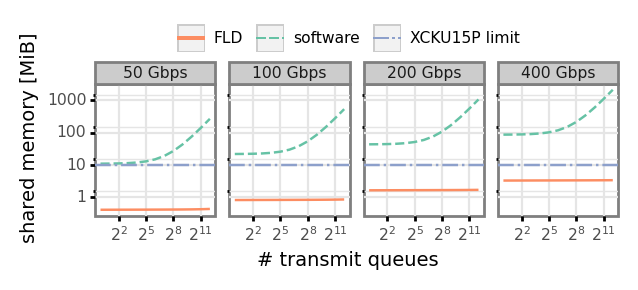

<ggplot: (8779789271796)>

In [14]:
def linerate_labeller(linerate):
    return f'{linerate} Gbps'

def log2_labeller(breaks):
    return [f'$2^{{{i}}}$' for i in np.log2(breaks).astype('int')]

def minor_breaks(limits):
    major = [10 ** i for i in range(0, 5)]
    res = [m * 1.5 for m in major
           if m * 1.5 < limits[1]]
    return res

limit_xcku15p_df = pd.DataFrame({'type': ['BRAM', 'URAM', 'LUTRAM'],
  'Mibit': [34.6, 36, 9.8]})
limit_xcku15p_mib = limit_xcku15p_df['Mibit'].sum() / 8

grid_color = p9.options.current_theme.themeables['panel_grid_major'].theme_element.properties['color']
ticks_color = "#000000"

df['total_mib'] = df['total_bytes'] / (2 ** 20)
df['fld_name'] = np.where(df['fld'], 'FLD', 'software')
plt = (p9.ggplot(df, p9.aes(x='num_tx_queues', y='total_mib', linetype='fld_name', color='fld_name')) +
  p9.geom_line() +
  p9.geom_hline(mapping=p9.aes(linetype=['XCKU15P limit'], color=['XCKU15P limit'], yintercept=limit_xcku15p_mib)) + 
  p9.scale_x_continuous(trans='log2', name='# transmit queues', labels=log2_labeller) +
  p9.scale_y_continuous(trans='log10', name='shared memory [MiB]',
      minor_breaks=minor_breaks) +
  p9.facet_grid('~ linerate_gbps', labeller=linerate_labeller) + 
  p9.theme(
    figure_size=(fig_width, 1),
    subplots_adjust={'top': 0.77},
    axis_ticks_minor_y=p9.element_line(ticks_color),
    panel_grid_minor_y=p9.element_line(color=grid_color, size=0.5),
  ) +
  top_legend + \
  p9.scale_color_manual(values=[fld_color, software_color, fpga_color])
)
plt

In [15]:
plt.save('mem_usage.pdf')

/home/haggai/miniconda3/envs/flc-model/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.37566 x 1 in image.
/home/haggai/miniconda3/envs/flc-model/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: mem_usage.pdf


In [16]:
reduction = copy(df)
reduction['tx_meta_total_bytes'] = reduction['txq_wq_bytes'] + reduction['txq_wq_translation_table_bytes']
reduction['tx_data_total_bytes'] = reduction['tx_outstanding_bytes'] + reduction['txq_data_translation_table_bytes']
reduction_cols = ['tx_meta_total_bytes', 'tx_data_total_bytes', 'total_cq_bytes', 'srq_wq_bytes', 'rx_outstanding_bytes', 'total_bytes']
reduction = reduction.pivot_table(values=reduction_cols, columns=['fld'], index=['linerate_gbps', 'num_tx_queues'])

def slice_fld(df, fld):
    new_df = df.loc[:, [(col, fld) for col in reduction_cols]]
    new_df.columns = new_df.columns.droplevel(1)
    return new_df

no_fld = slice_fld(reduction, False)
fld = slice_fld(reduction, True)
ratio = no_fld / fld
ratio.columns = pd.MultiIndex.from_tuples((c, 'ratio') for c in ratio.columns)
reduction = pd.concat([reduction, ratio], axis=1)#.sort_values(by=1, axis=1)
reduction.columns.names = ['type', 'col']
reduction = reduction.sort_values(by=['type', 'col'], axis=1)
reduction[[(col, 'ratio') for col in reduction_cols]].loc[(100, 512)]

type                  col  
tx_meta_total_bytes   ratio    2080.507937
tx_data_total_bytes   ratio      28.177440
total_cq_bytes        ratio       4.266667
srq_wq_bytes          ratio            inf
rx_outstanding_bytes  ratio      29.753344
total_bytes           ratio     105.018071
Name: (100, 512), dtype: float64